<a href="https://colab.research.google.com/github/alisher-turubayev/dl-normalizing-flows/blob/master/etc/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizing Normalizing Flows for Anime Face Generation - Journey Log
## Google Colab Training Loop & Demostration

**Alisher Turubayev, M.Sc. in Digital Health Student**

*Deep Learning Course, Summer 2022 - Hasso-Plattner Institute*



---



This Google Colab notebook is submitted as part of the final project on normalizing flows & anime face generation. The associated files (such as the final PDF report, PyTorch code and related files) can be found on the [Github project repository](https://github.com/alisher-turubayev/dl-normalizing-flows).

### Acknowledgements
The author would like to thank the project supervisor, Eshant English, Researcher/PhD candidate at the Hasso-Plattner Institute, for continued guidance throughout the project. 

### References
1. *Glow: Generative Flow with Invertible 1×1 Convolutions* (arXiv: [1807.03039](https://arxiv.org/abs/1807.03039))
2. *Density Estimation Using Real NVP* (arXiv: [1605.08803](https://arxiv.org/pdf/1605.08803.pdf))

### Code References
1. [*PyTorch implementation of realNVP by @fmu2*](https://github.com/fmu2/realNVP) for RealNVP implementation using PyTorch;
2. [*DCGAN PyTorch Tutorial by @inkawhich*](https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py)
3. [*PyTorch implementations of algorithms for density estimation*](https://github.com/ikostrikov/pytorch-flows) for general inspiration/code structure;

### Dataset
[Kaggle Anime Face Dataset](https://www.kaggle.com/datasets/splcher/animefacedataset)

**Note:** the dataset was prunned, subset, and randomly split before using in training/validation. See Training Loop for details.

## Training Loop

**Explanation:**

The author did not possess a videocard at the time of completing this project; therefore, the resources of the Google Colab were used. 

The next cells essentially show the training process as it was completed by the author.

In [ ]:
!git clone https://github.com/alisher-turubayev/dl-normalizing-flows

In [ ]:
!cd dl-normalizing-flows/; git pull

In [4]:
!mkdir datasets; mkdir datasets/kaggle-full; mkdir datasets/kaggle-full/data

In [5]:
!unzip -qq -d datasets/kaggle-full/data drive/MyDrive/DeepLearningFiles/Datasets/kaggle-full.zip

**Note:**

The original dataset is ~64k images; however, about ~17k images are smaller than 64x64. As per discussions with the project supervisor, these images were prunned from the dataset, resulting in 47,775 images. 

The script for image prunning written in Bash is available in the [GitHub repository](https://github.com/alisher-turubayev/dl-normalizing-flows/tree/master/utils) for the project. 

The script can be run in Google Colab - one can copy the Bash script into a separate cell and do dataset prunning within the Google Colab environment. However, the author of this project has done it on a local machine.

**Additional remarks on the dataset usage:**

While the dataset is ~47k, loading that into the RAM/GPU RAM is impossible on the free tier of Google Colab. Instead, the author has decided to settle on a 100 batches (with standard batch size of 64) of randomly selected images - 6400 images out of ~47k.

If and when a local machine with a CUDA-accelerated graphics card becomes available, there is a strong argument to re-run the experiments and get improved results of all models. 

In [6]:
!ls datasets/kaggle-full/data | wc -l

47775


### RealNVP training

The following cells start the RealNVP model training.

#### Parameters:

Several models were trained:

First, training was done with the following parameters:
1. 50 epochs - 50 epochs - 50 epochs - 20 epochs (170 total)
2. Random seed at each training pass
3. Training/validation split of 90% to 10%
4. Image size of 32 x 32, 3 channels
5. Recursive repeat of multi-scale architecture until input of the last recursion of 16 x 16 x 6 (H x W x C)
6. Residual blocks - 8
7. Features per residual block - 64

Second training was done with the following parameters:
1. 25 epochs - 25 epochs - 25 epochs (75 total)
2. Random seed at each training pass
3. Training/validation split of 90% to 10%
4. Image size of 64 x 64 x 3
5. Recursive repeat of architecture until input of last recursion of 4 x 4 x 48
6. Residual blocks - 4
7. Features per block - 32

Third training was done with the following parameters:
1. 25 epochs - 25 epochs - 25 epochs (75 total)
2. Fixed seed of 409 (lucky number) for all training passes
3. Training/validation split of 90% to 10%
4. Image size of 64 x 64 x 3
5. Recursive repeat of architecture until input of last recursion of 4 x 4 x 48
6. Residual blocks - 4
7. Features per block - 32


#### Results:

*Note:* training was done with in passes of either 50 epochs or 25 epochs at a time - mainly due to the limitations of Google Colab free tier. While the author has purchased access to Google Colab Pro later during the project, no significant differences were observed between the two tiers to justify longer training at a time.


**First model:**
Final output:
```
::Mean bits per dims: 4.111659628261474
::Mean validation bits per dims: 4.107114361205154
Training finished at epoch 170 with log-likelihood 8289.3087890625
```

While bits per dimension statistic is larger than original paper's result of **3.49** on *CIFAR-10* dataset, the model is not trainable beyond 170 epochs (after ~173 epochs, which corresponds to about ~15,300 iterations, the model's *z* collapses? to `numpy.nan` and refuses to generate further results/work at all). Being unable to debug the issue (the author tried to use [validate_args = False](https://github.com/pytorch/pytorch/issues/59228) because they believed that the issue is due to differing PyTorch version), the model architecture was not further explored due to low performance and aformentioned problems in training.


**Second model:**
Final output:
```
::Mean bits per dims: 3.364413724522876
::Mean validation bits per dims: 3.7236912404092233
Training finished at epoch 75 with log-likelihood 37546.599609375
```

Compared to the original RealNVP paper, the number of residual blocks is higher, though not by design - originally, the author wanted to have 8 residual blocks and 64 features per block as in the first case. Having more residual blocks increases RAM/VRAM usage beyond free/Pro tier limitations. 

Far better results were achieved in both qualitative and quantitative metrics. However, when analysing samples from the second model, a certain bluriness was noted. Believing that the random seed mode (which determines the subsetting of the dataset) is the culprit, the model was retrained one last time with a fixed seed over all training passes.

**Third model:**

Third model was trained with a fixed seed of 409. For this model, quantitative metrics are available as plots (see Data Plotting section) Additionally, generated images smoothened out over time, suggesting overfitting by the model (perhaps due to a small size of the subsetted training data - only 6,400 images).

In [ ]:
# For new training of RealNVP on random seed
!python3 dl-normalizing-flows/main.py --algo realnvp --epochs 25 --res-blocks 4 --base-dim 32 --datapath datasets --output-dir drive/MyDrive/DeepLearningFiles/Outputs --nofixed

In [ ]:
# For retraining/continuing training for RealNVP on random seed
!python3 dl-normalizing-flows/main.py --algo realnvp --epochs 25 --res-blocks 4 --base-dim 32 --datapath datasets --image-size 64 --output-dir drive/MyDrive/DeepLearningFiles/Outputs --nofresh --saved-path drive/MyDrive/DeepLearningFiles/Outputs/states --nofixed

In [ ]:
# For new training of RealNVP on fixed seed
!python3 dl-normalizing-flows/main.py --algo realnvp --epochs 25 --res-blocks 4 --base-dim 32 --datapath datasets --output-dir drive/MyDrive/DeepLearningFiles/Outputs --fixed-seed 409

In [ ]:
# For retraining/continuing training for RealNVP on fixed seed
!python3 dl-normalizing-flows/main.py --algo realnvp --epochs 25 --res-blocks 4 --base-dim 32 --datapath datasets --image-size 64 --output-dir drive/MyDrive/DeepLearningFiles/Outputs --nofresh --saved-path drive/MyDrive/DeepLearningFiles/Outputs/states --fixed-seed 409

### DCGAN

#### Parameters

The model was trained with random seed for 500 epochs single pass. Two separate models were trained. Learning rate, weight decay were left the same as RealNVP.

#### Results

For the first model, the loss was not properly stored (I had an error in the code that wasn't calculating mean loss; instead, the last calculated loss was outputted). The second model has corrected loss output, and the result is provided in the plot in section 'Data Plotting'.

Qualitative analysis shows subjectively better results, though both models suffer from darkened images. This is because of an error in how images are saved (images were not normalized to [0, 1]). The final code submission has this issue fixed.

In [ ]:
!python3 dl-normalizing-flows/main.py --algo gan --epochs 500 --datapath datasets --output-dir drive/MyDrive/DeepLearningFiles/Outputs --nofixed

## Samples

In [ ]:
# Import required libraries for the following section
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow
import cv2

# All samples are available in the Github repository
!git clone https://github.com/alisher-turubayev/dl-normalizing-flows

### RealNVP Samples

For the first model, samples from 100 epochs, 150 epochs and 170 epochs are presented.

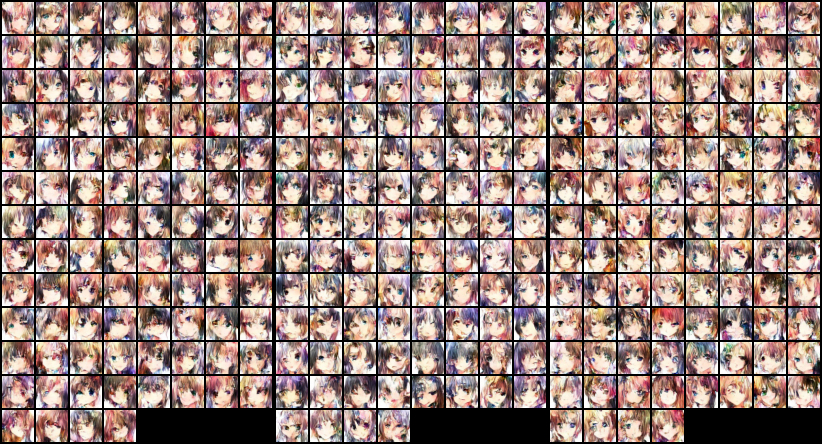

In [9]:
img = cv2.imread('dl-normalizing-flows/samples/realnvp_cifar_progression.jpg')

cv2_imshow(img)

For the second model, only 25 and 75 epoch results were saved (unfortunately, the 50 epoch result was overriden).

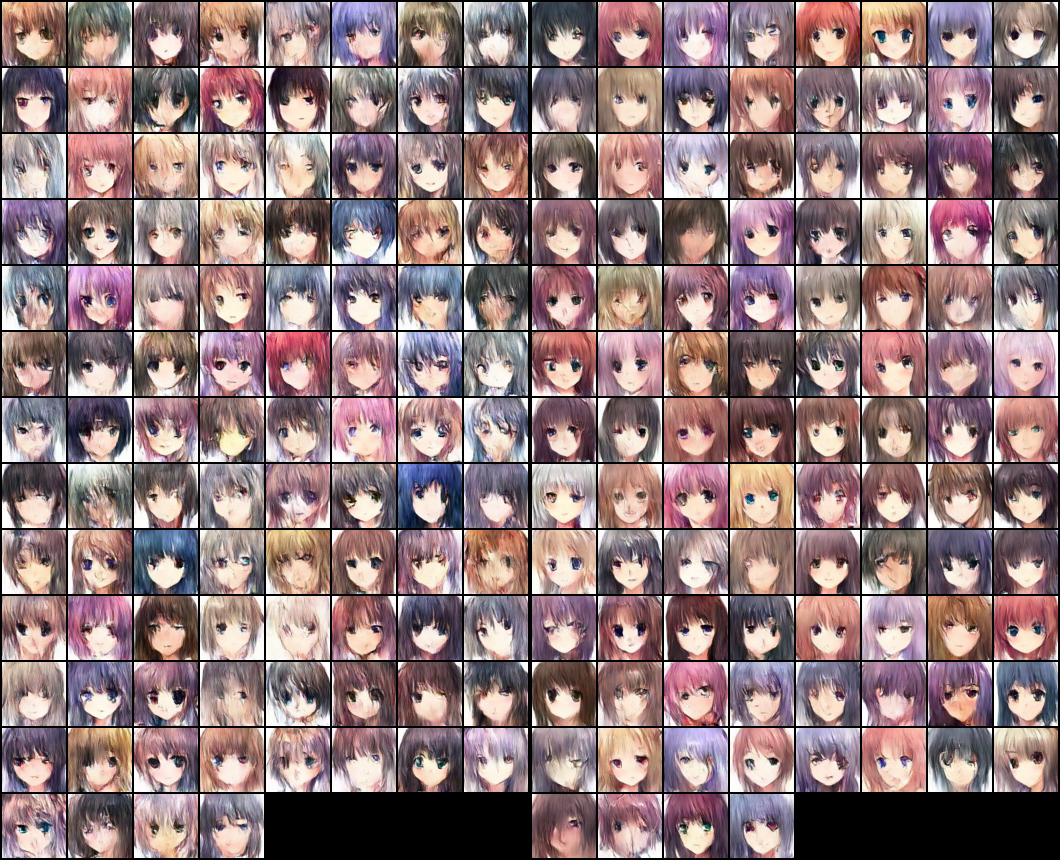

In [10]:
img = cv2.imread('dl-normalizing-flows/samples/realnvp_celeba_random_progression.jpg')

cv2_imshow(img)

For the third model, samples after 25, 50 and 75 epochs are presented.

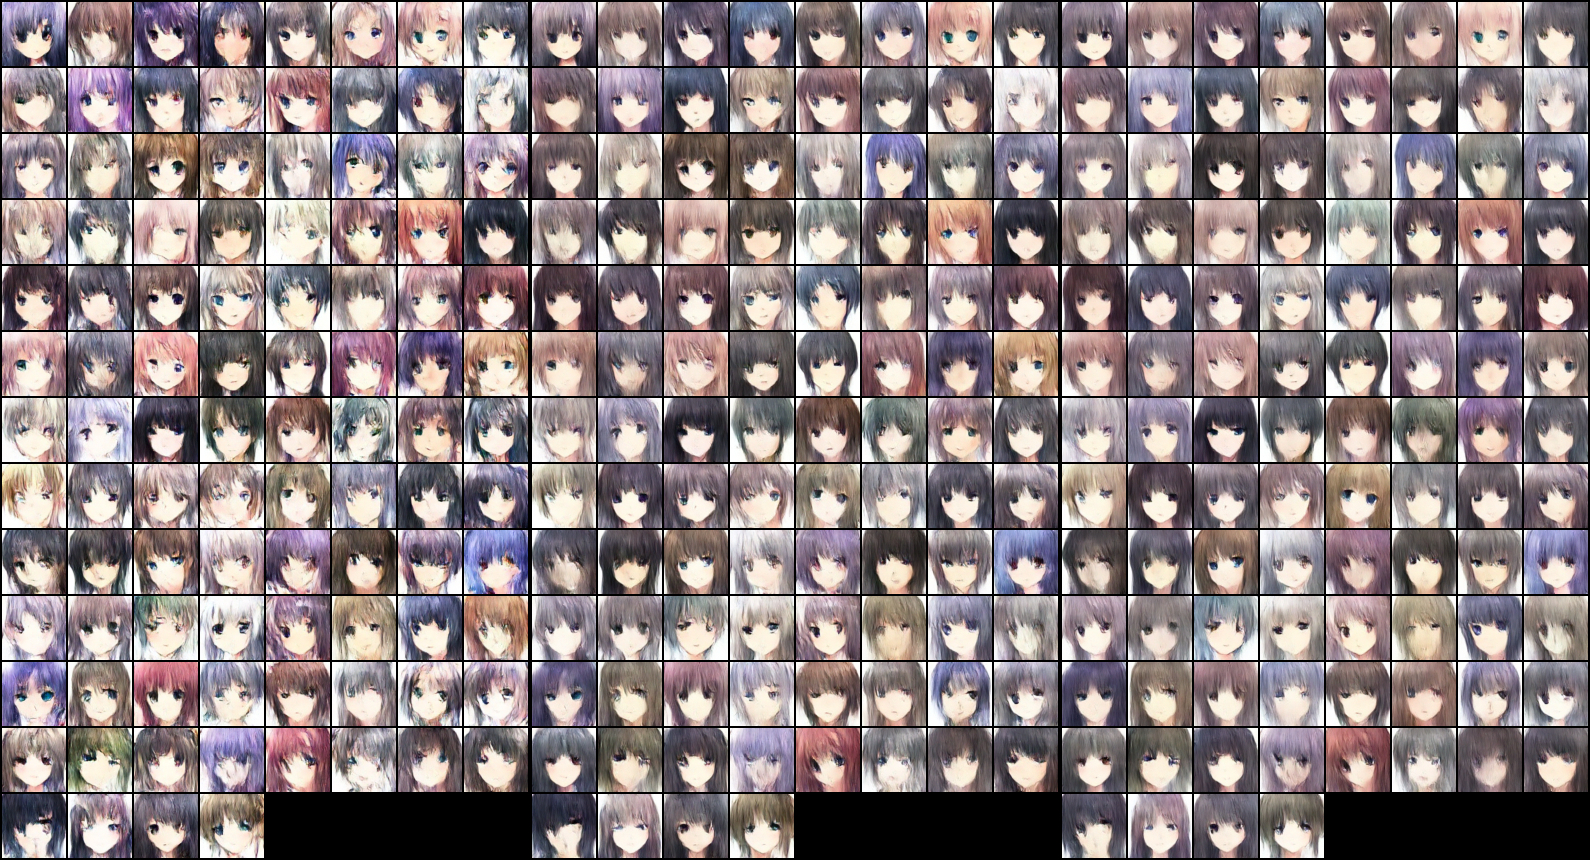

In [11]:
img = cv2.imread('dl-normalizing-flows/samples/realnvp_celeba_fixed_progression.jpg')

cv2_imshow(img)

### DCGAN Samples

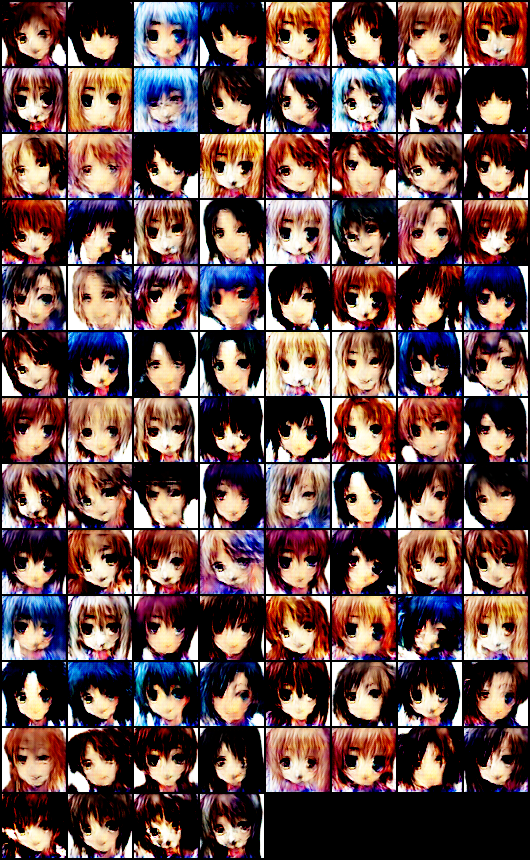

In [26]:
img = cv2.imread('dl-normalizing-flows/samples/img_dcgan.png')

cv2_imshow(img)

## Data Plotting

### DCGAN Loss over time:

`DiscLoss` stands for discriminator loss; `GenLoss` for generator loss.

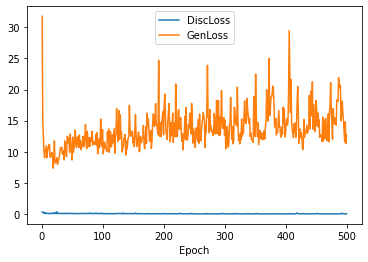

In [14]:
df = pd.read_csv('dl-normalizing-flows/etc/dcgan_loss.csv')

df.plot(kind = 'line', x = 'Epoch')

### RealNVP Fixed Seed Bits Per Dimension & Log-Likelihood Plots

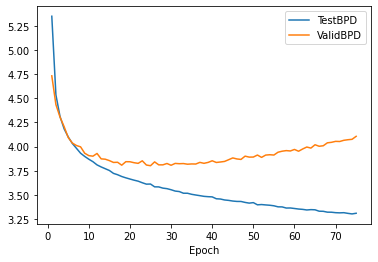

In [15]:
df = pd.read_csv('dl-normalizing-flows/etc/realnvp_bpd.csv')

df.plot(kind = 'line', x = 'Epoch')

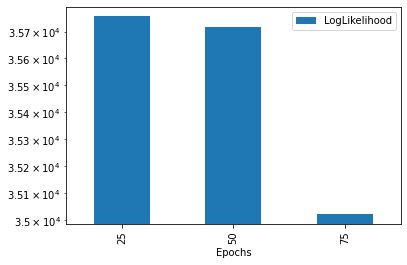

In [18]:
df = pd.read_csv('dl-normalizing-flows/etc/realnvp_logll.csv')

df.plot(kind = 'bar', x = 'Epochs', logy = True)